# USA Airlines delay on 2008 

# 1. Carga de datos.

Carga de librerías necesarias.

In [1]:
# Carga de librerías

# Data wrangling
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# Graficos
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

---

He descargado los siguientes archivos:

1. DelayedFlights.csv
2. airports.csv
3. carriers.csv
4. plane-data.csv

de la página: https://www.kaggle.com/giovamata/airlinedelaycauses

--- 
 
El dataset principal, DelayedFlights.csv contiene información de vuelos en EEUU desde los años 1987 hasta 2008. En este caso, el archivo que vamos a cargar solo contiene los datos referidos a 2008.

Las variables incluidas son las siguientes: 

|Number |	Name |	Description|
---:|:---|:---
1| 	Year |	1987-2008 // *La versión que hemos descargado solo tiene los datos de 2008*
2 |	Month |	1-12
3 |	DayofMonth |	1-31
4 |DayOfWeek |	1 (Monday) - 7 (Sunday)
5 |	DepTime |	actual departure time (local, hhmm)
6 |	CRSDepTime |	scheduled departure time (local, hhmm)
7 |	ArrTime |	actual arrival time (local, hhmm)
8 |	CRSArrTime |	scheduled arrival time (local, hhmm)
9 |	UniqueCarrier| 	unique carrier code
10| 	FlightNum |	flight number
11| 	TailNum |	plane tail number
12| 	ActualElapsedTime |	in minutes
13| 	CRSElapsedTime |	in minutes
14| 	AirTime |	in minutes
15| 	ArrDelay |	arrival delay, in minutes
16| 	DepDelay |	departure delay, in minutes
17| 	Origin |	origin IATA airport code
18| 	Dest |	destination IATA airport code
19| 	Distance |	in miles
20| 	TaxiIn |	taxi in time, in minutes
21| 	TaxiOut |	taxi out time in minutes
22| 	Cancelled |	was the flight cancelled?
23| 	CancellationCode |	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24| 	Diverted |	1 = yes, 0 = no
25| 	CarrierDelay |	in minutes
26| 	WeatherDelay |	in minutes
27| 	NASDelay |	in minutes
28| 	SecurityDelay |	in minutes
29| 	LateAircraftDelay |	in minutes


In [2]:
# Carga del archivo principal.
vuelos_raw=pd.read_csv('DelayedFlights.csv',sep=',')

In [3]:
pd.options.display.max_columns

20

In [4]:
# Como hay más de veinte variables voy a modificar el número de columnas que Pandas nos mostrará.
pd.set_option('display.max_columns', None)

# 2. Limpieza y preprocesado del dataset.

## 2.1. Exploración inicial.

In [5]:
# Variables disponibles.
vuelos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

In [6]:
# Missing Values para el dataset.
vuelos_raw.isna().sum()

Unnamed: 0                0
Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                7110
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   5
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7110
TaxiOut                 455
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64

En una primera exploración del conjunto de datos, vemos que hay 30 variables y más de 1.900.000 observaciones. Hay una primera variable 'Unnamed:0' que parece un índice y voy a eliminar por que no aporta valor a la tabla.

Entre las primeras variables tenemos los datos de año, mes, dia y días de la semana. Quiero conservar estas columnas por que me servirán para hacer agrupaciones de cara a posteriores análisis. El tipo int64 está bien inferido.

A continuación en el dataset hay cuatro variables correspondientes a las horas programadas de llegada y salida y las horas reales. Parece que pandas ha inferido el tipo como int64 o float64. Para posteriores análisis quiero conservar la variable hora programada de salida ('CRSDepTime'), pero para simplificar solo quiero extraer el valor de la hora del día. Hay diferentes formas de conseguir ese valor, en este caso voy a probar a dividir entre 100 y convertir a entero.  

Antes de eliminar las columnas de horas, veo que el campo ArrTime tiene 7110 valores nulos. Podría tratarse de vuelos que no llegaron a su destino, para confirmarlo comprobaremos que se corresponden con la variable 'Cancelled' o 'Diverted'.
Como no hay dato de hora de llegada tampoco hay dato para el tiempo que el vuelo estuvo en el suelo en el aeropuerto de destino ('Taxiin')

Variables como 'UniqueCarrier' me dan información sobre la compañía aérea que puedo cruzar si utilizo la tabla carriers.csv, con la variable 'tailnum' podría buscar información sobre año de fabricación de los aviones y con las variables 'Dest' y 'Origin' o 'FlightNum' puedo inferir datos geográficos como Ciudad, Estado, etc. 

Hay 8387 registros para los que no tenemos información del tiempo de vuelo, ni del retraso en la llegada. Estos podrían ser vuelos que nunca despegaron. Además hay 198 vuelos donde no hay información del tiempo de vuelo estimado ('CRSElapsedTime') que vamos a analizar en detenimiento para entender que ocurrió y 5 vuelos que no tienen registrada la matrícula del avión.

Por último, en el dataset tengo cinco variables que son las que imputan los minutos de retraso a una causa determinada, (a la compañía, al tiempo, a la NAS, a temas de seguridad o al vuelo previo). que tienen valores Nan. Como veremos más adelante, la imputación de una causa de retraso está sujeta a que el retraso sea mayor de un valor.





In [7]:
# Slice del dataset para su análisis
vuelos_raw.iloc[294860:294870]

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
294860,938194,2008,2,27,3,1423.0,1416,1632.0,1623,F9,677,N941FR,249.0,247.0,229.0,9.0,7.0,MCO,DEN,1545,5.0,15.0,0,N,0,NaN,NaN,NaN,NaN,NaN
294861,938203,2008,2,27,3,2106.0,2100,2220.0,2220,F9,576,N944FR,74.0,80.0,50.0,0.0,6.0,SLC,DEN,391,15.0,9.0,0,N,0,NaN,NaN,NaN,NaN,NaN
294862,938224,2008,2,28,4,1854.0,1807,1946.0,1902,F9,773,N201FR,112.0,115.0,91.0,44.0,47.0,DEN,LAS,629,8.0,13.0,0,N,0,44.0,0.0,0.0,0.0,0.0
294863,938225,2008,2,28,4,1854.0,1807,1946.0,1902,F9,773,N201FR,112.0,115.0,91.0,44.0,47.0,DEN,LAS,629,8.0,13.0,0,N,0,44.0,0.0,0.0,0.0,0.0
294864,938226,2008,2,28,4,2027.0,1942,2314.0,2229,F9,780,N201FR,107.0,107.0,84.0,45.0,45.0,LAS,DEN,629,10.0,13.0,0,N,0,1.0,0.0,44.0,0.0,0.0
294865,938227,2008,2,28,4,2027.0,1942,2314.0,2229,F9,780,N201FR,107.0,107.0,84.0,45.0,45.0,LAS,DEN,629,10.0,13.0,0,N,0,1.0,0.0,44.0,0.0,0.0
294866,938228,2008,2,28,4,933.0,910,1053.0,1040,F9,225,N801FR,140.0,150.0,124.0,13.0,23.0,DEN,SMF,910,5.0,11.0,0,N,0,NaN,NaN,NaN,NaN,NaN
294867,938229,2008,2,28,4,1126.0,1120,1438.0,1435,F9,539,N801FR,132.0,135.0,115.0,3.0,6.0,SMF,DEN,910,6.0,11.0,0,N,0,NaN,NaN,NaN,NaN,NaN
294868,938233,2008,2,28,4,606.0,600,853.0,849,F9,774,N802FR,107.0,109.0,83.0,4.0,6.0,LAS,DEN,629,6.0,18.0,0,N,0,NaN,NaN,NaN,NaN,NaN
294869,938238,2008,2,28,4,2158.0,2140,2339.0,2329,F9,861,N802FR,101.0,109.0,84.0,10.0,18.0,DEN,PHX,602,6.0,11.0,0,N,0,NaN,NaN,NaN,NaN,NaN


Voy a generar un campo fecha que más adelante será útil para hacer agregaciones por día del año.

In [8]:
#Creado un duplicado del archivo original que voy a modificar.
vuelos=vuelos_raw.copy()

#Generar un campo con la fecha:
vuelos.rename(columns={'DayofMonth':'Day'},inplace=True)
vuelos['Date']=pd.to_datetime(vuelos[['Year','Month','Day']])


In [9]:
# Número de días con vuelos registrados:
vuelos['Date'].unique().shape[0]

366

El dataset ha registrado vuelos 366 días, lo que significa que 2008 era bisiesto.

## 2.2. Registros duplicados.

In [10]:
# Búsqueda de duplicados
vuelos[vuelos.duplicated()]
# Parece que no hay duplicados

,Unnamed: 0,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date


In [11]:
# Elimino el campo unnamed: 0
vuelos.drop(labels='Unnamed: 0', axis=1,inplace=True)

In [12]:
vuelos.columns

Index(['Year', 'Month', 'Day', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Date'],
      dtype='object')

In [13]:
vuelos[vuelos.duplicated()]

,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
294863,2008,2,28,4,1854.0,1807,1946.0,1902,F9,773,N201FR,112.0,115.0,91.0,44.0,47.0,DEN,LAS,629,8.0,13.0,0,N,0,44.0,0.0,0.0,0.0,0.0,2008-02-28
294865,2008,2,28,4,2027.0,1942,2314.0,2229,F9,780,N201FR,107.0,107.0,84.0,45.0,45.0,LAS,DEN,629,10.0,13.0,0,N,0,1.0,0.0,44.0,0.0,0.0,2008-02-28


A primera vista, parecía que no hay observaciones duplicadas. Sin embargo, cuando eliminamos la primera columna, nos encontramos con dos registros duplicados. Procedemos a eliminarlos.

In [14]:
vuelos.drop_duplicates(inplace=True)
vuelos.shape[0]

1936756

## 2.3. Entendiendo los _missing values_ del dataset.
### 2.3.1. Missing values asociados a vuelos cancelados o desviados.

Hay un grupo de celdas con valores nulos en las variables _'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', ArrDelay', 'TaxiIn' y 'TaxiOut'_ que da la sensación de que corresponden a vuelos cancelados o desviados. Veamos la proporción de estos incidentes y si estos valores tienen sentido. 

In [15]:
vuelos['Diverted'].value_counts()

0    1929002
1       7754
Name: Diverted, dtype: int64

In [16]:
vuelos['Cancelled'].value_counts()

0    1936123
1        633
Name: Cancelled, dtype: int64

In [17]:
#Total de vuelos cancelados
print('El total de vuelos cancelados es: ',vuelos[vuelos['Cancelled']==1].shape[0])
#Total de vuelos desviados
print('El total de vuelos desviados es: ',vuelos[vuelos['Diverted']==1].shape[0])

print('La suma de los dos incidencias es: ',vuelos[vuelos['Cancelled']==1].shape[0]+vuelos[vuelos['Diverted']==1].shape[0])

El total de vuelos cancelados es:  633
El total de vuelos desviados es:  7754
La suma de los dos incidencias es:  8387


In [18]:
# Vuelos cancelados según causa (A = carrier, B = weather, C = NAS, D = security)
vuelos[(vuelos['Cancelled']==1)]['CancellationCode'].value_counts()

B    307
A    246
C     80
Name: CancellationCode, dtype: int64

Parece que este grupo de variables con valores nulos corresponden a vuelos cancelados o desviados. Más adelante hablaré sobre como los voy a gestionar.

### 2.3.2. Vuelos sin información sobre la matrícula del avión.

Voy examinar aquellos vuelos que no tienen recogida la matricula del avión.

In [19]:
vuelos[vuelos['TailNum'].isna()]

,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
433449,2008,3,21,5,1333.0,1320,NaN,1428,OH,5338,NaN,NaN,68.0,NaN,NaN,13.0,CVG,GRR,268,NaN,16.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-03-21
523748,2008,3,18,2,1716.0,1655,2036.0,1947,9E,3760,NaN,140.0,112.0,100.0,49.0,21.0,DSM,DTW,534,11.0,29.0,0,N,0,0.0,0.0,28.0,0.0,21.0,2008-03-18
773772,2008,5,8,4,1545.0,1530,1711.0,1707,OH,5043,NaN,86.0,97.0,66.0,4.0,15.0,CVG,CHS,497,5.0,15.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-05-08
776480,2008,5,31,6,1720.0,1244,1920.0,1427,OH,5396,NaN,120.0,103.0,72.0,293.0,276.0,RDU,JFK,426,8.0,40.0,0,N,0,0.0,276.0,17.0,0.0,0.0,2008-05-31
1309410,2008,8,2,6,1840.0,1305,NaN,1438,OH,5731,NaN,NaN,93.0,NaN,NaN,335.0,RDU,ATL,356,NaN,6.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-08-02


Quiero explorar las coincidencias con el número de vuelo y día para ver si el vuelo era compartido con otra compañía y por eso no se informó de la matrícula del avión.

In [20]:
# Explorar coincidencias con número de vuelo y día
vuelos.query('(FlightNum ==5043 and Day==8 and Month==5) or (FlightNum ==5338 and Day==21 and Month==3) or (FlightNum ==3760 and Day==18 and Month==3) or (FlightNum ==5396 and Day==31 and Month==5) or (FlightNum ==5731 and Day==2 and Month==8)')

,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
433449,2008,3,21,5,1333.0,1320,NaN,1428,OH,5338,NaN,NaN,68.0,NaN,NaN,13.0,CVG,GRR,268,NaN,16.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-03-21
523748,2008,3,18,2,1716.0,1655,2036.0,1947,9E,3760,NaN,140.0,112.0,100.0,49.0,21.0,DSM,DTW,534,11.0,29.0,0,N,0,0.0,0.0,28.0,0.0,21.0,2008-03-18
773772,2008,5,8,4,1545.0,1530,1711.0,1707,OH,5043,NaN,86.0,97.0,66.0,4.0,15.0,CVG,CHS,497,5.0,15.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-05-08
773773,2008,5,8,4,1130.0,1101,1518.0,1438,OH,5043,N409CA,168.0,157.0,142.0,40.0,29.0,SAT,CVG,1024,3.0,23.0,0,N,0,0.0,29.0,11.0,0.0,0.0,2008-05-08
776480,2008,5,31,6,1720.0,1244,1920.0,1427,OH,5396,NaN,120.0,103.0,72.0,293.0,276.0,RDU,JFK,426,8.0,40.0,0,N,0,0.0,276.0,17.0,0.0,0.0,2008-05-31
1309410,2008,8,2,6,1840.0,1305,NaN,1438,OH,5731,NaN,NaN,93.0,NaN,NaN,335.0,RDU,ATL,356,NaN,6.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-08-02
1314533,2008,8,2,6,1349.0,1337,1512.0,1451,OO,5731,N393SW,83.0,74.0,61.0,21.0,12.0,GEG,SEA,224,6.0,16.0,0,N,0,12.0,0.0,9.0,0.0,0.0,2008-08-02
1384628,2008,8,2,6,1626.0,1340,1902.0,1630,9E,5731,85879E,96.0,110.0,81.0,152.0,166.0,MEM,CHS,589,3.0,12.0,0,N,0,0.0,152.0,0.0,0.0,0.0,2008-08-02


Parece que no es el caso, además resulta que el número de vuelo no es un identificador único de la ruta.


Por lo tanto, voy a suponer que se debe a un error de transcripción, así que imputaré a estos 5 valores Nan con la cadena 'Unknown'.

In [21]:
# Utilizando la función fillna
vuelos.fillna({'TailNum':'Unknown'},inplace=True)


In [22]:
vuelos[vuelos['TailNum']=='Unknown']

,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
433449,2008,3,21,5,1333.0,1320,NaN,1428,OH,5338,Unknown,NaN,68.0,NaN,NaN,13.0,CVG,GRR,268,NaN,16.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-03-21
523748,2008,3,18,2,1716.0,1655,2036.0,1947,9E,3760,Unknown,140.0,112.0,100.0,49.0,21.0,DSM,DTW,534,11.0,29.0,0,N,0,0.0,0.0,28.0,0.0,21.0,2008-03-18
773772,2008,5,8,4,1545.0,1530,1711.0,1707,OH,5043,Unknown,86.0,97.0,66.0,4.0,15.0,CVG,CHS,497,5.0,15.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-05-08
776480,2008,5,31,6,1720.0,1244,1920.0,1427,OH,5396,Unknown,120.0,103.0,72.0,293.0,276.0,RDU,JFK,426,8.0,40.0,0,N,0,0.0,276.0,17.0,0.0,0.0,2008-05-31
1309410,2008,8,2,6,1840.0,1305,NaN,1438,OH,5731,Unknown,NaN,93.0,NaN,NaN,335.0,RDU,ATL,356,NaN,6.0,0,N,1,NaN,NaN,NaN,NaN,NaN,2008-08-02


In [23]:
vuelos['TailNum'].isna().sum()

0

### 2.3.3. Missing values asociados a la causa de retraso.

Como comenté en apartado inicial, hay un valor limite de tiempo de retraso por debajo del cual no se asignan valores a la causa de retraso.

In [24]:
causas=['NASDelay','WeatherDelay','SecurityDelay','LateAircraftDelay']
for i in causas:
    print(i,vuelos[vuelos[i].isna()].ArrDelay.max())

NASDelay 14.0
WeatherDelay 14.0
SecurityDelay 14.0
LateAircraftDelay 14.0


In [25]:
for i in causas:
    print(i,vuelos[vuelos[i].notnull()].ArrDelay.min())

NASDelay 15.0
WeatherDelay 15.0
SecurityDelay 15.0
LateAircraftDelay 15.0


Los vuelos con más de 14 minutos de retraso se consideran **retrasados** y se les asigna una causa, para el resto de ocasiones tenemos un Nan. 

## 2.4. Selección y preparación de variables.

Para hacer una selección adecuada de variables, necesito tener claro cuales son las preguntas que quiero responder o dicho de otra manera, que información necesito extraer de mis datos.

Para ser más concreto, estas son algunas de las respuestas que quiero conocer:

- ¿Cual es la tendencia en el tiempo en el número de vuelos?.
- ¿Está relacionada esta tendencia con el retraso en los vuelos?
- ¿Que compañías acumulan más retrasos? 
- ¿Que aeropuertos sufren mayores retrasos?
- ¿Cuales son los factores que más influyen en los retrasos?
- Distancia recorrida, velocidad y antigüedad de la flota, ¿son relevantes en los retrasos?

### 2.4.1. Variables relacionadas con la fecha y la hora.

Para analizar la tendencia de vuelo voy a quedarme con una única variable, la hora del día de salida a la que estaba programado el vuelo. El resto de variables (_'DepTime', 'ArrTime', 'CRSArrTime'_) no las necesito. Como expliqué anteriormente voy a dividir entre 100 y convertir en entero el valor de la variable _'CRSDepTime'_.

In [26]:
vuelos['Hour']=(vuelos['CRSDepTime']/100).astype('int32')

Crearé una variable que sea el día del año. 

In [27]:
# Obtengo día del año en función de la fecha
vuelos['DayOfYear']=vuelos['Date'].dt.dayofyear.astype('int32')

In [28]:
# Elimino las columnas DepTime, ArrTime, CRSArrTime
vuelos.drop(['CRSDepTime','DepTime', 'ArrTime', 'CRSArrTime'],inplace=True,axis=1)
vuelos.columns

Index(['Year', 'Month', 'Day', 'DayOfWeek', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Date', 'Hour', 'DayOfYear'],
      dtype='object')

### 2.4.2. Variables relacionadas con el retraso.

La variable que voy a usar como indicador de retraso es _'ArrDelay'_ que indica el retraso a la llegada. De momento  voy a conservar para el análisis las variables _'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay' y 'LateAircraftDelay'._ 

Creo la variable 'Status' con los valores 'On time' si hay retraso inferior a 15 minutos, 'Delayed' si tiene retraso entre 15 minutos y una hora, 'Highly Delayed', 'Cancelled y 'Diverted' si el vuelo fue cancelado o desviado.

In [29]:
# Variable categórica / esta retrasado?
vuelos['Status']='No'
vuelos.loc[(vuelos['ArrDelay']<15),'Status']='On time'
vuelos.loc[(vuelos['ArrDelay']>=15),'Status']='Delayed'
vuelos.loc[(vuelos['ArrDelay']>=60),'Status']='Highly Delayed'
vuelos.loc[vuelos['Diverted']==1,'Status']='Diverted'
vuelos.loc[vuelos['Cancelled']==1,'Status']='Cancelled'



In [30]:
# Re ordernando categoria

STATUS_CAT = CategoricalDtype(categories=['On time',
                                          'Delayed',
                                          'Highly Delayed',
                                          'Diverted',
                                          'Cancelled'], 
                                          ordered=True)

vuelos.Status=vuelos.Status.astype(STATUS_CAT)


Las variables TaxiIn y TaxiOut indican el tiempo que el avión está en tierra antes de despegar y cuando aterriza. Este valor computa dentro del tiempo de vuelo, junto con el tiempo en el aire y en vuelos retrasados suele ser mayor. 

A continuación un histograma de estas variables.

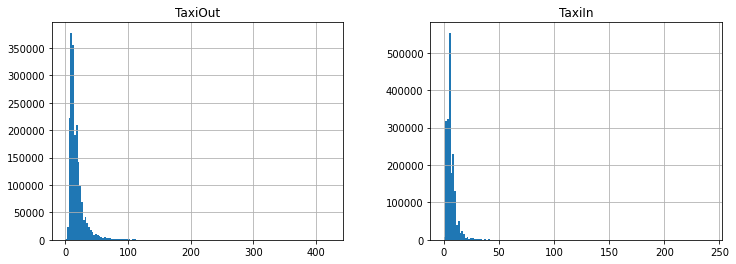

In [31]:
vuelos[['TaxiOut','TaxiIn']].hist(bins=150, figsize=(12,4));

Como se aprecia son distribuciones con asimetría positiva, donde la media no es representativa de la distribución y en este caso es mayor que la mediana. ~~Para el análisis la vamos a descartar, aunque probablemente si entrasemos a analizar en profundidad la saturación de los aeropuertos o en que aeropuertos los aviones permanece más tiempo en tierra, serían variables que podrían aportar información~~.

### 2.4.3. Variables relacionadas con la ruta del vuelo.

Voy a crear una nueva variable, la variable trayecto que me servirá para detectar que vuelos generan más retrasos.

In [32]:
vuelos['Skyway']=vuelos['Origin'].str.cat(vuelos['Dest'],sep='-')

In [33]:
vuelos['Skyway'].unique().shape

(5205,)

Existen 5.205 trayectos diferentes. Más adelante analizaremos cuales sufren mayor retraso.

## 2.5. Combinando dataframes

Además de este dataset tengo a mi disposición tres dataset más con datos sobre los aeropuertos, las compañías y los aviones.

Vamos a selecionar que información podría ser útil para responder a nuestras preguntas.

A continuación cargaré los csv correspondientes y los prepararé para unir con el dataset original. Utilizaré el comando merge y haré un "join" tipo "left", por que quiero que me mantenga todos los registros del dataset vuelos_c y me carge los registros coincidentes de la segunda tabla.

### 2.5.1. Aviones.

In [34]:
# Cargo la información de los aviones.
aviones=pd.read_csv('plane-data.csv')

In [35]:
aviones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


In [36]:
aviones.tail(3)

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998
5028,N999DN,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992


Parece que hay un conjunto de aviones de los que no hay datos. He revisado alguna de estas matrículas y parace que no tienen el formato expedido por la ATA. Podría tratarse de aeronaves matriculadas en otro país, también podría tratarse de una matrícula antigua con un formato no reconocido o bien se puede deber a un error en la transcripción.   

De esta tabla voy a extraer el año de fabricación.

Por lo tanto eliminaré las filas sin información.

In [37]:
# Elimino Nan
aviones.dropna(inplace=True)

In [38]:
# Duplicados
aviones[aviones.duplicated()].count()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
dtype: int64

In [39]:
# Valores únicos de año de manufactura.
aviones.year.unique()

array(['2004', '1998', '1986', '1999', '2002', '1994', '2003', '2005',
       '2006', '2000', '2001', '1997', '1995', '1996', '1987', '1985',
       'None', '1988', '1968', '1990', '1991', '1969', '1970', '1992',
       '1993', '1965', '1989', '1959', '1980', '2008', '1983', '0000',
       '1984', '2007', '1967', '1975', '1979', '1957', '1974', '1978',
       '1963', '1956', '1972', '1962', '1973', '1982', '1976', '1964',
       '1977', '1946', '1966', '1971'], dtype=object)

El campo año de manufactura tiene dos valores fuera de lo esperado, 'None' y '0000'. Vamos a analizar estos datos y ver si puedo imputar algún valor a esta columna.

In [40]:
aviones.loc[(aviones['year']=='None'),:]

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
138,N12528,Corporation,EMBRAER,05/31/2002,EMB-135LR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
280,N14558,Corporation,EMBRAER,05/29/2002,EMB-145LR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
342,N15555,Corporation,EMBRAER,06/07/2002,EMB-145LR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
344,N15574,Corporation,EMBRAER,10/02/2002,EMB-145LR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
481,N17358,Corporation,BOMBARDIER INC,12/29/2000,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
...,...,...,...,...,...,...,...,...,...
4882,N958UW,Corporation,EMBRAER,04/04/2008,ERJ 190-100 IGW,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
4887,N959UW,Corporation,EMBRAER,04/18/2008,ERJ 190-100 IGW,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
4982,N983AT,Corporation,BOEING,12/07/2005,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,None
4992,N986CA,Corporation,CANADAIR,02/04/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,None


In [41]:
aviones.loc[(aviones['year']=='0000'),:]

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
725,N235SW,Corporation,EMBRAER,03/19/1996,EMB-120ER,Valid,Fixed Wing Multi-Engine,Turbo-Prop,0000
962,N298AE,Corporation,SAAB-SCANIA,05/15/1998,SAAB 340B,Valid,Fixed Wing Multi-Engine,Turbo-Prop,0000
1489,N384AE,Corporation,SAAB-SCANIA,10/29/1996,SAAB 340B,Valid,Fixed Wing Multi-Engine,Turbo-Prop,0000


Hay un total de 148 registros sin el año de fabricación. Voy a extraer el año en que se registró la aeronave _issue_date_ y asumo que será igual que el año de fabricación.

In [42]:
# Extraigo el año del campo Issue_date y lo asigno a year.
aviones.loc[(aviones['year']=='None')|(aviones['year']=='0000'),'year']=aviones['issue_date'].str.split('/',expand=True)[2]
aviones.loc[aviones['year']=='None',:]
aviones.iloc[[138,280,725,962,1489],:]

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
172,N13161,Corporation,EMBRAER,04/29/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004
314,N14937,Corporation,EMBRAER,02/23/1998,EMB-145EP,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1997
763,N245AY,Corporation,BOEING,04/24/2007,767-201,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1987
1001,N306UA,Corporation,BOEING,02/19/1987,737-322,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1987
1546,N398CA,Corporation,BOMBARDIER INC,08/22/2003,CL-600-2C10,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2003


In [43]:
aviones.year.unique()

array(['2004', '1998', '1986', '1999', '2002', '1994', '2003', '2005',
       '2006', '2000', '2001', '1997', '1995', '1996', '1987', '1985',
       '1988', '1968', '1990', '1991', '1969', '1970', '1992', '1993',
       '1965', '1989', '1959', '2008', '1980', '1983', '1984', '2007',
       '1967', '1975', '1979', '1957', '1974', '1978', '1963', '1956',
       '1972', '1977', '1962', '1973', '1982', '1976', '1964', '1946',
       '1966', '1971'], dtype=object)

Ahora que tengo todos los aviones con un año de fabricación solo tengo que cambiar el tipo a entero.

In [44]:
aviones['Manuf_year']=aviones['year'].astype('int')


In [45]:
aviones['Manuf_year'].describe()

count    4480.000000
mean     1997.061607
std         7.554151
min      1946.000000
25%      1992.000000
50%      1999.000000
75%      2002.000000
max      2008.000000
Name: Manuf_year, dtype: float64

In [46]:
vuelos_c=vuelos.merge(aviones[['Manuf_year']],how='left', left_on='TailNum',right_on=aviones['tailnum'])

### 2.5.2. Compañías.

In [47]:
# Carga de los datos de las compañías.
carriers=pd.read_csv('carriers.csv')

In [48]:
carriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         1490 non-null   object
 1   Description  1491 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [49]:
carriers.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [50]:
carriers[carriers['Code'].isna()]

,Code,Description
873,NaN,North American Airlines


In [51]:
carriers[carriers['Description']=='North American Airlines']

,Code,Description
873,NaN,North American Airlines


In [52]:
# Duplicados
carriers[carriers.duplicated()].sum()

Code           0.0
Description    0.0
dtype: float64

In [53]:
vuelos_c=vuelos_c.merge(carriers['Description'],how='left', left_on='UniqueCarrier',right_on=carriers['Code'])

### 2.5.3. Aeropuertos.

In [54]:
# Carga de la base de datos de aeropuertos.
airports=pd.read_csv('airports.csv')

In [55]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3364 non-null   object 
 3   state    3364 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


In [56]:
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [57]:
airports.state.unique()

array(['MS', 'TX', 'CO', 'NY', 'FL', 'AL', 'WI', 'OH', 'MO', 'MN', 'IN',
       'NV', 'IL', 'ND', 'MI', 'NE', 'GA', 'DC', 'TN', 'AK', 'ME', 'MA',
       'VT', 'SD', 'NM', 'OK', 'KS', 'KY', 'IA', 'AR', 'LA', 'CA', 'WA',
       'VA', 'AZ', 'PA', 'NJ', 'OR', 'NC', 'UT', 'MT', 'ID', 'CT', 'SC',
       'NH', 'MD', 'DE', 'WV', 'WY', 'PR', 'RI', nan, 'AS', 'CQ', 'GU',
       'HI', 'VI'], dtype=object)

57 corresponde a 50 estados + 1 distrito federal + 5 territorios + un Nan.

In [58]:
airports[airports['state'].isna()]

,iata,airport,city,state,country,lat,long
1136,CLD,MC Clellan-Palomar Airport,NaN,NaN,USA,33.127231,-117.278727
1715,HHH,Hilton Head,NaN,NaN,USA,32.224384,-80.697629
2251,MIB,Minot AFB,NaN,NaN,USA,48.415769,-101.358039
2312,MQT,Marquette County Airport,NaN,NaN,USA,46.353639,-87.395361
2752,RCA,Ellsworth AFB,NaN,NaN,USA,44.145094,-103.103567
2759,RDR,Grand Forks AFB,NaN,NaN,USA,47.961167,-97.401167
2794,ROP,Prachinburi,NaN,NaN,Thailand,14.078333,101.378334
2795,ROR,Babelthoup/Koror,NaN,NaN,Palau,7.367222,134.544167
2900,SCE,University Park,NaN,NaN,USA,40.851206,-77.846302
2964,SKA,Fairchild AFB,NaN,NaN,USA,47.615058,-117.655803


In [59]:
airports[airports['state'].isna()].index

Int64Index([1136, 1715, 2251, 2312, 2752, 2759, 2794, 2795, 2900, 2964, 3001,
            3355],
           dtype='int64')

In [60]:
airports[airports['country']=='N Mariana Islands']

,iata,airport,city,state,country,lat,long
3001,SPN,Tinian International Airport,NaN,NaN,N Mariana Islands,14.996111,145.621384


In [61]:
airports[airports['state']=='MP']

,iata,airport,city,state,country,lat,long


In [62]:
# Diccionario con los datos que faltan y el índice

indices={1136:['Carlsbad','CA'],
        1715: ['Hilton Head Island','SC'],
        2251: ['Minot', 'ND'],
        2312: ['Marquette', 'MI'],
        2752: ['Ellsworth' , 'ND'],
        2759: ['Grand Forks', 'ND'],
        2794:['Thailand','Thailand'],
        2795: ['Palau', 'Palau'],
        2900: ['State college', 'PA'],
        2964: ['FairChild', 'WA'],
        3001:['Saipan', 'MP'],
        3355:['Yap','YAP']
        }

In [63]:
for i,v in indices.items():
    airports.loc[i,['city','state']]=v

In [64]:
airports.loc[1136,:]

iata                              CLD
airport    MC Clellan-Palomar Airport
city                         Carlsbad
state                              CA
country                           USA
lat                           33.1272
long                         -117.279
Name: 1136, dtype: object

In [65]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3376 non-null   object 
 3   state    3376 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


Una vez completados los valores nulos, uno los dataframes.

In [66]:
vuelos_c=vuelos_c.merge(airports[['city','state','country']],how='left', left_on='Origin',right_on=airports['iata'])

In [67]:
vuelos_c.isna().sum()

Year                      0
Month                     0
Day                       0
DayOfWeek                 0
UniqueCarrier             0
FlightNum                 0
TailNum                   0
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7110
TaxiOut                 455
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
Date                      0
Hour                      0
DayOfYear                 0
Status                    0
Skyway                    0
Manuf_year           198385
Description               0
city                      0
state                     0
country                   0
dtype: int64

Hay 198385 vuelos de los que no tengo datos sobre el avión.

Reorganizo de nuevo los campos.

In [68]:
columnas = list(vuelos_c.columns.values)
vuelos_c=vuelos_c.rename(columns={'Description':'CarrierName','Manuf_year':'YearOfManufact',
                                  'city':'city_or','state':'state_or'})

Vuelvo a unir dataframes para extraer la información del destino.

In [69]:
vuelos_c=vuelos_c.merge(airports[['city','state']],how='left', left_on='Dest',right_on=airports['iata'])
vuelos_c=vuelos_c.rename(columns={'city':'city_dest','state':'state_dest'})

In [70]:
vuelos_c.drop(['CRSElapsedTime',
               'ActualElapsedTime',
               'Cancelled',
               'Diverted',],inplace=True,axis=1)

In [71]:
columnas =[ 'Date','DayOfYear','Year','Month','Day','DayOfWeek','Hour',
 'Status','ArrDelay','DepDelay','TaxiIn','TaxiOut', 'CancellationCode', 
 'UniqueCarrier','CarrierName','TailNum','YearOfManufact',
 'Origin','Dest','FlightNum','Distance','Skyway','city_or','state_or','country','city_dest','state_dest',
 'CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']


In [72]:
vuelos_c=vuelos_c[columnas]

### Sobre el uso de memoria.

Voy a intentar rebajar el uso de la memoria forzando los tipos de las variables.

In [73]:
vuelos_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936756 entries, 0 to 1936755
Data columns (total 32 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   DayOfYear          int32         
 2   Year               int64         
 3   Month              int64         
 4   Day                int64         
 5   DayOfWeek          int64         
 6   Hour               int32         
 7   Status             category      
 8   ArrDelay           float64       
 9   DepDelay           float64       
 10  TaxiIn             float64       
 11  TaxiOut            float64       
 12  CancellationCode   object        
 13  UniqueCarrier      object        
 14  CarrierName        object        
 15  TailNum            object        
 16  YearOfManufact     float64       
 17  Origin             object        
 18  Dest               object        
 19  FlightNum          int64         
 20  Distance           int64

In [74]:
vuelos_c.astype({'Year':'int32',
                'Month':'uint8',
                'Day':'uint8',
                'DayOfWeek':'uint8',
                'Hour':'uint8',
                'UniqueCarrier':'category',
                'TailNum':'category',
                'Origin':'category',
                'Dest':'category',
                'CancellationCode':'category',
                'DayOfYear':'int32',
                'state_or':'category',
                'country':'category',
                'state_dest':'category'}).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936756 entries, 0 to 1936755
Data columns (total 32 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   DayOfYear          int32         
 2   Year               int32         
 3   Month              uint8         
 4   Day                uint8         
 5   DayOfWeek          uint8         
 6   Hour               uint8         
 7   Status             category      
 8   ArrDelay           float64       
 9   DepDelay           float64       
 10  TaxiIn             float64       
 11  TaxiOut            float64       
 12  CancellationCode   category      
 13  UniqueCarrier      category      
 14  CarrierName        object        
 15  TailNum            category      
 16  YearOfManufact     float64       
 17  Origin             category      
 18  Dest               category      
 19  FlightNum          int64         
 20  Distance           int64

Una vez preparado el dataframe, han quedado 8387 valores Nan en las variables ArrDelay y Speed_mph que corresponden a vuelos que fueron cancelados o desviados. De momento no imputo ningún valor.

Otros 689270 valores Nan los encontramos en el conjunto de datos referidos al retraso imputado a cada causa cuando no hubo retraso. 

In [75]:
vuelos_c.to_csv('vuelos_final.csv',index=False)

In [76]:
# Preparo una copia para entrar en el análisis exploratorio.
#df=vuelos_c.copy()

In [77]:
# df from csv
df=pd.read_csv('vuelos_final.csv')

# 3. Análisis exploratorio de los datos. 

Voy a hacer un primer análisis utilizando la función describe.

In [78]:
df.describe()

,DayOfYear,Year,Month,Day,DayOfWeek,Hour,ArrDelay,DepDelay,TaxiIn,TaxiOut,YearOfManufact,FlightNum,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.936756e+06,1936756.0,1.936756e+06,1.936756e+06,1.936756e+06,1.936756e+06,1.928369e+06,1.936756e+06,1.929646e+06,1.936301e+06,1.738371e+06,1.936756e+06,1.936756e+06,1.247486e+06,1.247486e+06,1.247486e+06,1.247486e+06,1.247486e+06
mean,1.712009e+02,2008.0,6.111111e+00,1.575346e+01,3.984827e+00,1.439864e+01,4.219988e+01,4.318517e+01,6.812973e+00,1.823221e+01,1.997542e+03,2.184265e+03,7.656863e+02,1.917939e+01,3.703577e+00,1.502162e+01,9.013728e-02,2.529651e+01
std,1.070209e+02,0.0,3.482546e+00,8.776268e+00,1.995967e+00,4.244424e+00,5.678474e+01,5.340253e+01,5.273597e+00,1.433854e+01,7.221218e+00,1.944703e+03,5.744799e+02,4.354623e+01,2.149292e+01,3.383307e+01,2.022716e+00,4.205488e+01
min,1.000000e+00,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.090000e+02,6.000000e+00,0.000000e+00,0.000000e+00,1.956000e+03,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.800000e+01,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,1.100000e+01,9.000000e+00,1.200000e+01,4.000000e+00,1.000000e+01,1.993000e+03,6.100000e+02,3.380000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.660000e+02,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.500000e+01,2.400000e+01,2.400000e+01,6.000000e+00,1.400000e+01,1.999000e+03,1.543000e+03,6.060000e+02,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,8.000000e+00
75%,2.530000e+02,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.800000e+01,5.600000e+01,5.300000e+01,8.000000e+00,2.100000e+01,2.003000e+03,3.422000e+03,9.980000e+02,2.100000e+01,0.000000e+00,1.500000e+01,0.000000e+00,3.300000e+01
max,3.660000e+02,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.300000e+01,2.461000e+03,2.467000e+03,2.400000e+02,4.220000e+02,2.008000e+03,9.742000e+03,4.962000e+03,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03


El output de la función describe contiene mucha información sobre la distribución de nuestras variables pero a primera vista es incómodo de leer e interpretar, y en general es más intuitivo ver una representación visual.

Para entender como se comportan nuestras variables vamos a ir analizándolas más detalladamente.

## 3.1. Distribución de los vuelos según el estado.

In [79]:
delayed={'On time':0,
         'Delayed':1,
         'Highly Delayed':1,
         'Diverted':2,
         'Cacelled':2}
df['Is_Delayed']=df['Status'].map(delayed)

In [80]:
# Porcentaje de vuelos retrasados
df.Is_Delayed.value_counts(normalize=True)*100

1.0    64.432167
0.0    35.167342
2.0     0.400491
Name: Is_Delayed, dtype: float64

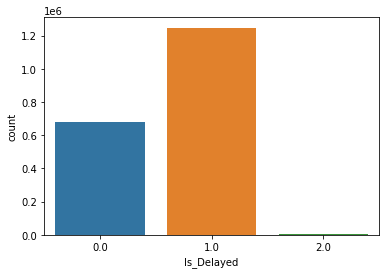

In [81]:
sns.countplot(data=df,
             x='Is_Delayed');

In [82]:
# Porcentaje de vuelos según su estado
round(df.groupby('Status')['Day'].count()/len(df)*100,2)

Status
Cancelled          0.03
Delayed           41.29
Diverted           0.40
Highly Delayed    23.12
On time           35.16
Name: Day, dtype: float64

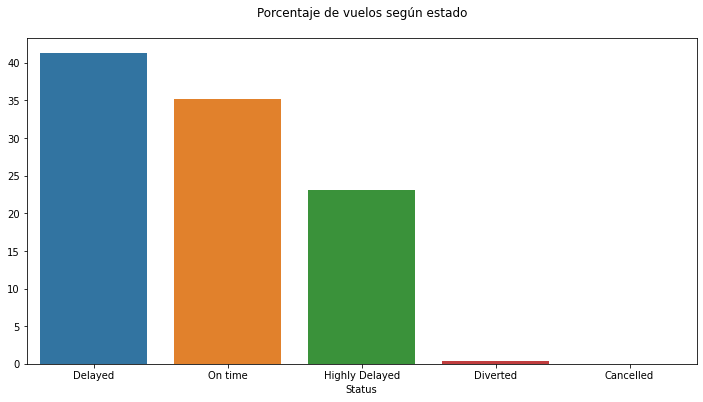

In [83]:
fig, ax = plt.subplots(figsize=(12,6))

sta=(df[['Status']].value_counts(normalize=True)*100).to_frame().reset_index()

# Ax plot
sns.barplot(data=sta,
            x='Status',
            y=0,)
           

# Tunning plot
ax.set_title('Porcentaje de vuelos según estado\n')
ax.set_ylabel('');


Como podemos ver en 2008 hubo un 35,2 % de vuelos que salieron a tiempo, frente a un 64,4 % de vuelos que salieron con retraso. Además un 0,4 % de los vuelos fueron desviados y un 0,03 % cancelado.

## 3.2. Tendencias temporales.

Ahora que sabemos que proporción de vuelos sufrieron retraso vamos a ver la frecuencia de vuelos distribuida en el tiempo y los retrasos sufridos cada periodo.

El numero de vuelos representado por mes y dia del año se distribuye de la siguiente manera:

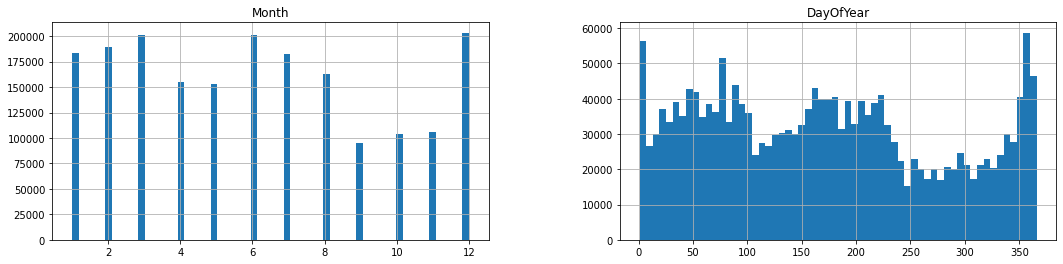

In [84]:
df[['Month','DayOfYear']].hist(bins=60, figsize=(18,4));

Mientras que si representamos el volumen de vuelos por día del mes, dia de la semana o hora del día se observa la siguiente distribución.

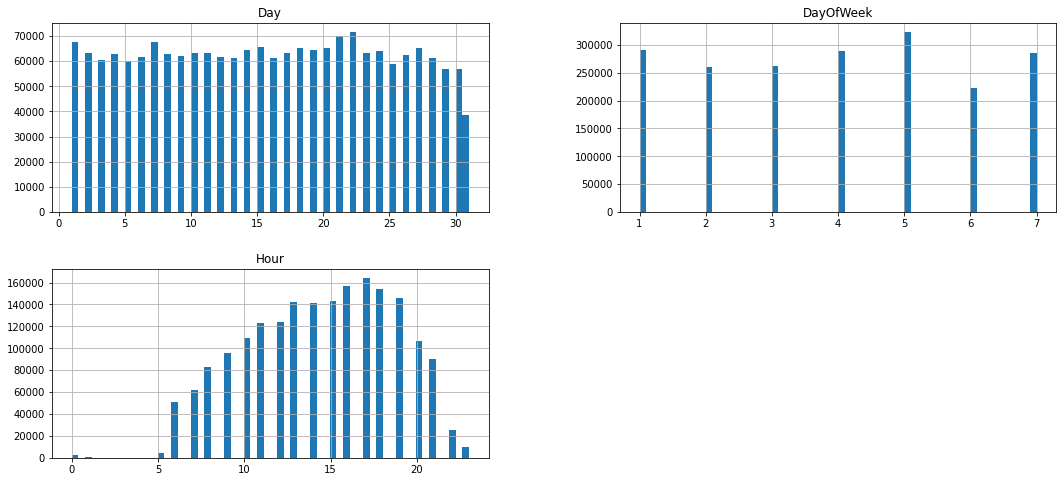

In [85]:
df[['Day','DayOfWeek','Hour']].hist(bins=60, figsize=(18,8));

Parece que se observa una mayor tendencia a volar en el primer y el tercer tremestre. Los meses con mayor frecuencia de vuelo son marzo, junio y diciembre. Estos picos se podrían explicar por periodos vacacionales, la pascua de 2008 que cayó en marzo, las vacaciones de verano y navidad. Si nos vamos al gráfico de días del año, esto tiene correspondencia, siendo los periodos más significativos los primeros días del año y los últimos.

Por otro lado, no parece observarse una tendencia en como se distribuyen los vuelos en los días del mes. Aunque si lo analizamos como día de la semana, los viernes y los lunes son los días con mayores vuelos y el sábado el día que menos se vuela. 

En cuanto a la distribución horaria, apenas tenemos vuelos nocturnos y el 75% de los vuelos están concentrados entre las 11 y las 23 h, tiendo el máximo de frecuencia entre las 15 y las 18.

### 3.2.1. Como se comportan los retrasos.

Vamos a analizar ahora como se comportan los retrasos. Para ello vamos a ver la distribución de estas variables junto con la distribución del tiempo en tierra.

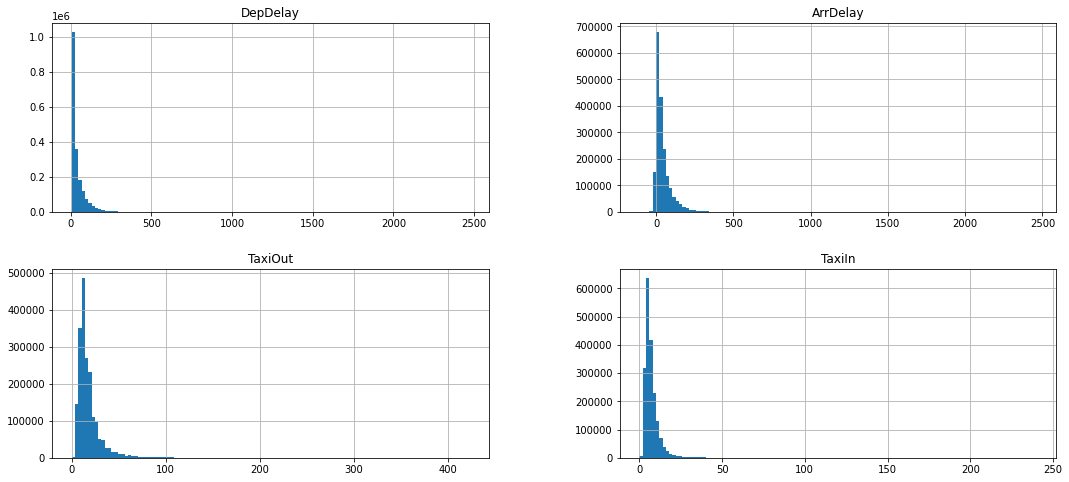

In [86]:
df[['DepDelay','ArrDelay','TaxiOut','TaxiIn']].hist(bins=120, figsize=(18,8));

In [87]:
# Valores estadísticos para los retrasos en los vuelos completados.
df[['DepDelay','ArrDelay','TaxiOut','TaxiIn']].describe()

,DepDelay,ArrDelay,TaxiOut,TaxiIn
count,1.936756e+06,1.928369e+06,1.936301e+06,1.929646e+06
mean,4.318517e+01,4.219988e+01,1.823221e+01,6.812973e+00
std,5.340253e+01,5.678474e+01,1.433854e+01,5.273597e+00
min,6.000000e+00,-1.090000e+02,0.000000e+00,0.000000e+00
25%,1.200000e+01,9.000000e+00,1.000000e+01,4.000000e+00
50%,2.400000e+01,2.400000e+01,1.400000e+01,6.000000e+00
75%,5.300000e+01,5.600000e+01,2.100000e+01,8.000000e+00
max,2.467000e+03,2.461000e+03,4.220000e+02,2.400000e+02


In [88]:
# Asimetría de las distribuciones.
df[['DepDelay','ArrDelay','TaxiOut','TaxiIn']].skew()

DepDelay    4.495075
ArrDelay    3.948778
TaxiOut     4.502008
TaxiIn      6.003436
dtype: float64

Los retrasos y los tiempos de espera en tierra a la salida y a la llegada se comportan de igual manera. Sus distribuciones tienen una simetría positiva y la mayoría de los valores se concentran en torno a la mediana (distribución leptucúrtica). Esto quiere decir que el pico de la distribución esta desplazado hacia la izquierda. 

La mediana de ambas distribuciones está en los 24 minutos de retraso, pero el valor máximo es de alrededor de 2460 minutos que son alrededor de unas 40 horas. El mínimo retraso a la llegada registrado es de -109 minutos.

Veamos en detalle la distribución de la variable ArrDelay.


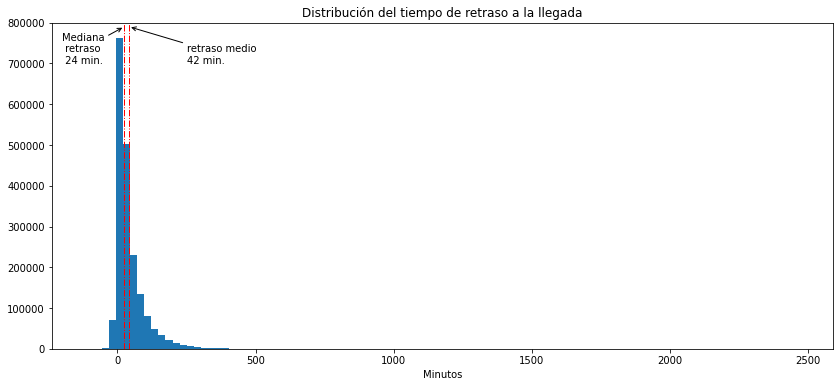

In [89]:

# Crear la figura
fig,ax = plt.subplots(figsize=(14,6))

# Preparar los datos

# Crear el gráfico

ax.hist(df.ArrDelay,
         bins=100, )

# Customizar el gráfico
# Anotación tiempo medio
ax.axvline(df.ArrDelay.mean(),color='r',linestyle='-.',linewidth= 1)
ax.annotate(text='retraso medio \n'+str(int(df.ArrDelay.mean()))+' min.',
            xy=(df.ArrDelay.mean(),790000),xytext=(250,700000),
            arrowprops=dict(arrowstyle='->'))


# Anotación mediana de retraso
ax.axvline(df.ArrDelay.median(),color='r',linestyle='-.',linewidth= 1)
ax.annotate(text='Mediana\n retraso\n '+str(int(df.ArrDelay.median()))+' min.',
            xy=(df.ArrDelay.median(),790000),xytext=(-200,700000),
            arrowprops=dict(arrowstyle='->'))

#Títulos
ax.set(title='Distribución del tiempo de retraso a la llegada',
       xlabel='Minutos')

# Guardar imagen
plt.savefig('distribucion_ArrDelay',dpi=200)




In [90]:
#sns.pairplot(df[['DepDelay','ArrDelay','TaxiOut','TaxiIn']]);

Representando en un gráfico de dispersión las variables Retraso a la llegada y retraso a la salida y en otro gráfico los retrasos frente al número de vuelos en un grafico de dispersión se puede inferir una conclusión muy rápida. 

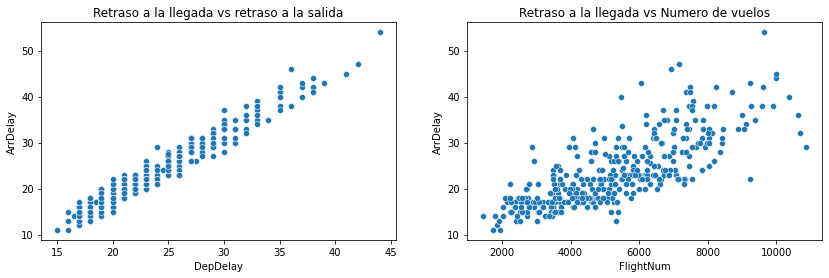

In [91]:
fig,(ax1,ax2) = plt.subplots(figsize=(14,4),ncols=2,nrows=1)

data=df.groupby(['DayOfYear']).agg({'DepDelay':'median','ArrDelay' : 'median','FlightNum':'count'})

# Ax1 - ArrDelay vs DepDelay
sns.scatterplot(data=data,y='ArrDelay',x='DepDelay',ax=ax1)
ax1.set(title='Retraso a la llegada vs retraso a la salida')

# Ax2 - ArrDelay vs NumFlights
sns.scatterplot(data=data,y='ArrDelay',x='FlightNum',ax=ax2)
ax2.set(title='Retraso a la llegada vs Numero de vuelos');

Parece que hay una tendencia a haber mayor retraso los días que hay mayor número de vuelos. Además observando el primer gráfico, mayor retraso en la llegada cuando hay mayor retraso en la salida.

### 3.2.2. Distribución de los retrasos en función de la fecha.

A continuación podemos ver la distribución por fechas de la frecuencia de los vuelos y del retraso promedio (mediana).

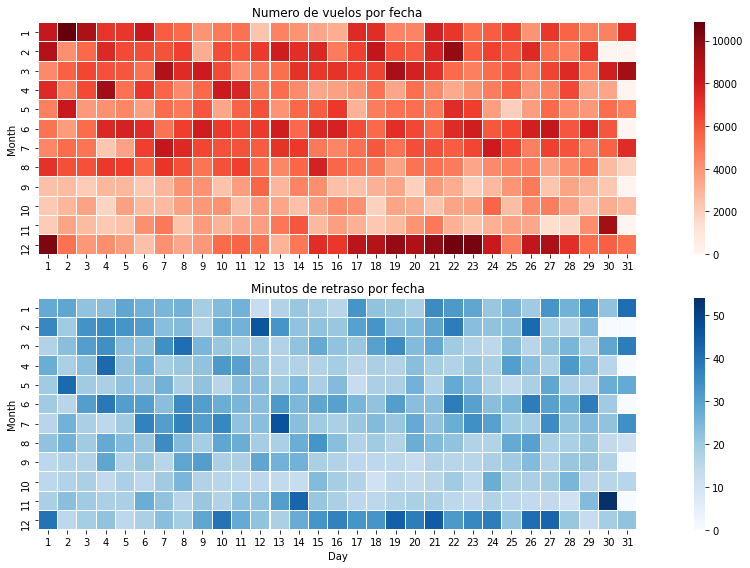

In [92]:
fig,(ax1,ax2) = plt.subplots(figsize=(16,8),ncols=1,nrows=2, tight_layout=True)

# Ax1 - Numero de vuelos por fecha
# Preparación de la tabla
mapa_vuelo=df.groupby(['Month','Day'])[['ArrDelay']].count().reset_index()
mapa_vuelo_pivot=mapa_vuelo.pivot(index='Month',columns='Day',values='ArrDelay').fillna(0)

# Tabla distribución retraso por fecha
sns.heatmap(mapa_vuelo_pivot,
            cmap='Reds',
            square=True,
            linewidths=0.05,
            ax=ax1);

ax1.set(title='Numero de vuelos por fecha',
        xlabel='')


# Ax2 - Minutos de retraso por fecha
# Preparación de la tabla
mapa_retraso=df.groupby(['Month','Day'])[['ArrDelay']].median().reset_index()
mapa_retraso_pivot=mapa_retraso.pivot(index='Month',columns='Day',values='ArrDelay').fillna(0)

# Tabla distribución retraso por fecha
sns.heatmap(mapa_retraso_pivot,
            cmap='Blues',
            square=True,
            linewidths=0.05,
           # center=15,
            ax=ax2)

ax2.set(title='Minutos de retraso por fecha');




De nuevo parece verse una tendencia a aumentar el tiempo de retraso medio cuando hay mayor número de vuelos.

Los mejores meses para volar fueron septiembre y octubre. Los peores periodos en cuanto a retraso los encontramos en las semanas previas a navidad, final de moviembre o la semana anterior al 14/7. 

## 3.3. Retrasos por compañías.

Queremos conocer ahora que compañías acumulan más retrasos, cuales tienen retrasos mayores y si esto es función de la flota.

In [93]:
df['UniqueCarrier'].unique()

array(['WN', 'XE', 'YV', 'OH', 'OO', 'UA', 'US', 'DL', 'EV', 'F9', 'FL',
       'HA', 'MQ', 'NW', '9E', 'AA', 'AQ', 'AS', 'B6', 'CO'], dtype=object)

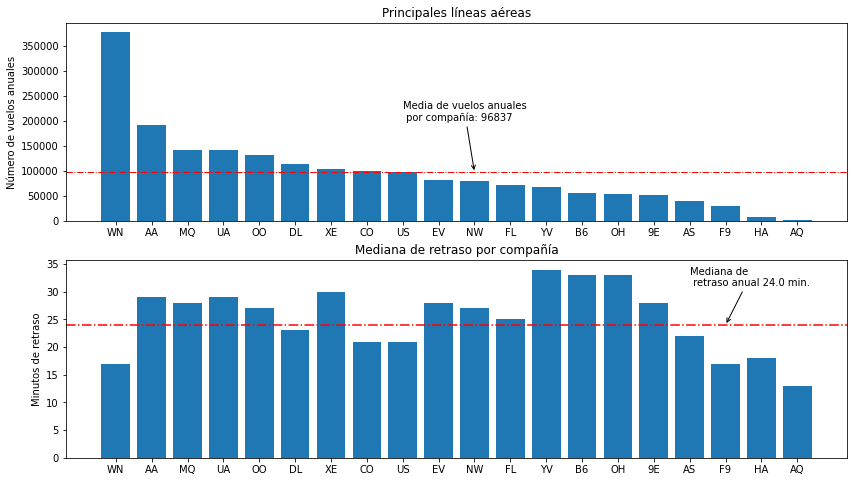

In [94]:
# Crear la figura
fig,(ax1,ax2)= plt.subplots(figsize=(14,8),nrows=2,ncols=1,sharex=False)

#Ax1 - Principlaes comapañías aéreas por volumen de vuelos
figura1=df.UniqueCarrier.value_counts().sort_values(ascending=False)

# Dibujar el gráfico
ax1.bar(x= figura1.index,
        height=figura1.values,)

# Customizar la imagen
# Dibujar una línea vertical con el valor de la media de vuelos
ax1.axhline(y=figura1.values.mean(),
           color='r',
           linestyle='-.',
           linewidth= 1)
# Anotación
ax1.annotate('Media de vuelos anuales\n por compañía: '+str(int(figura1.values.mean())),
            xy=(10,figura1.values.mean()),
            xytext=(8,200000),
            arrowprops=dict(arrowstyle='->'))
# Títulos
ax1.set(title='Principales líneas aéreas',
       ylabel='Número de vuelos anuales',);


# Preparar los datos
figura31=df.groupby('UniqueCarrier').ArrDelay.agg(['median','count']).sort_values(by='count', ascending=False)
# Ax2
# Dibujar el gráfico
ax2.bar(x=figura31.index,
       height=figura31['median'],)

# Customizar la imagen
# Añadir titulos
ax2.set(title='Mediana de retraso por compañía',
       ylabel='Minutos de retraso',)

# Anotaciones
# Linea horizontal
ax2.axhline(df.ArrDelay.median(),color='r',linestyle='-.')
# Anotación
ax2.annotate('Mediana de\n retraso anual '+str(df.ArrDelay.median())+' min.',
           xy=(17,df.ArrDelay.median()),
           xytext=(16,31),
          arrowprops=dict(arrowstyle='->'));



# Guardar imagen
#plt.savefig('valor_mediano_ArrDelay_por_compañia',dpi=200)



In [95]:
# Retraso promedio (mediana), retraso acumulado y número de vuelos en función de la compañía. 
df.groupby(['UniqueCarrier','CarrierName'])['ArrDelay'].agg([('Retraso (mediana)','median'),('Retraso acumulado (suma)','sum'),('total de vuelos','count')]).sort_values(by='Retraso (mediana)', ascending=[False])

,,Retraso (mediana),Retraso acumulado (suma),total de vuelos
UniqueCarrier,CarrierName,,,
YV,Mesa Airlines Inc.,34.0,3691461.0,66769
B6,JetBlue Airways,33.0,3025749.0,54925
OH,Comair Inc.,33.0,2675993.0,52453
XE,Expressjet Airlines Inc.,30.0,5176042.0,103147
AA,American Airlines Inc.,29.0,8889066.0,190910
UA,United Air Lines Inc.,29.0,6733013.0,140904
MQ,American Eagle Airlines Inc.,28.0,6396704.0,141223
9E,Pinnacle Airlines Inc.,28.0,2420468.0,51569
EV,Atlantic Southeast Airlines,28.0,3888131.0,81762


En esta tabla se presentan el total de minutos de retraso acumulado, el número de vuelos y la mediana de retraso que tiene cada compañía ordenados de mayor mediana de retraso a menor.

Como se aprecia las tres primeras compañías, Mesa, JetBlue y Comair, tienen una mediana de retraso en torno a los 33 minutos y hacen entre 50.000 y 66.00 vuelos al año. 

United Airlines y American Airlines se sitúan con un retraso de 29 minutos pero con el triple de vuelos.

Por último, Southwest Airlines con 376.000 vuelos anuales solo tiene 17 minutos de mediana de retraso.


### 3.3.1. Año de fabricación del avión, distancia de vuelo y retrasos.

A continuación vemos el porcentaje de vuelos por año de fabricación del avión y por distancia de viaje recorrida.

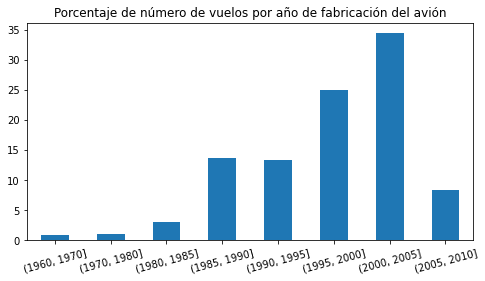

In [96]:
fig, (ax1) = plt.subplots(figsize=(8,4))

# Pandas plot
(
(pd.cut(df.YearOfManufact,bins=[1960,1970,1980,1985,1990,1995,2000,2005,2010])
 .value_counts(normalize=True)*100).sort_index().plot(kind='bar', ax=ax1)
    )
# Custom plot
ax1.set(title='Porcentaje de número de vuelos por año de fabricación del avión')
ax1.tick_params(axis='x', labelrotation = 15);



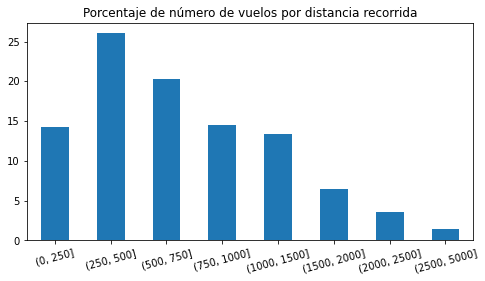

In [97]:
fig, (ax) = plt.subplots(figsize=(8,4))

# Pandas plot
(
(pd.cut(df.Distance,bins=[0,250,500,750,1000,1500,2000,2500,5000])
 .value_counts(normalize=True)*100).sort_index().plot(kind='bar', ax=ax)
    )
# Custom plot 
ax.set(title='Porcentaje de número de vuelos por distancia recorrida')
ax.tick_params(axis='x', labelrotation = 15);

Si agrupamos por compañía aérea, calculamos año medio de fabricación de la flota, mediana de retraso, número de vuelos, distancia de trayecto media y ordenamos por distancia de mayor a menos, tenemos la siguiente tabla:

In [98]:
# Año de fabricación promedio de todos los vuelos, retraso medio y distancia media por compañía.
delay_carrier=df.groupby(['UniqueCarrier','CarrierName']).agg({'YearOfManufact':'mean',
                                                               'ArrDelay':'median',
                                                               'Distance':'median',
                                                               'FlightNum':'count'}).sort_values(by=('Distance'),
                                                                                                 ascending=[False])
delay_carrier


,,YearOfManufact,ArrDelay,Distance,FlightNum
UniqueCarrier,CarrierName,,,,
CO,Continental Air Lines Inc.,1997.704429,21.0,1091,100195
AA,American Airlines Inc.,1986.537881,29.0,1045,191865
B6,JetBlue Airways,2004.636049,33.0,1035,55315
AS,Alaska Airlines Inc.,1999.002419,22.0,873,39293
F9,Frontier Airlines Inc.,2003.867053,17.0,862,28267
UA,United Air Lines Inc.,1994.217707,29.0,853,141426
DL,Delta Air Lines Inc.,1992.372233,23.0,732,114238
US,US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.),1995.863922,21.0,678,98425
FL,AirTran Airways Corporation,2002.734772,25.0,644,71284


Si agrupamos los promedios de distancia de vuelo, fecha y retraso por compañía no se observa un patron claro entre el retraso y otras variables. Probablemente hay algún factor más que influye en el retraso.

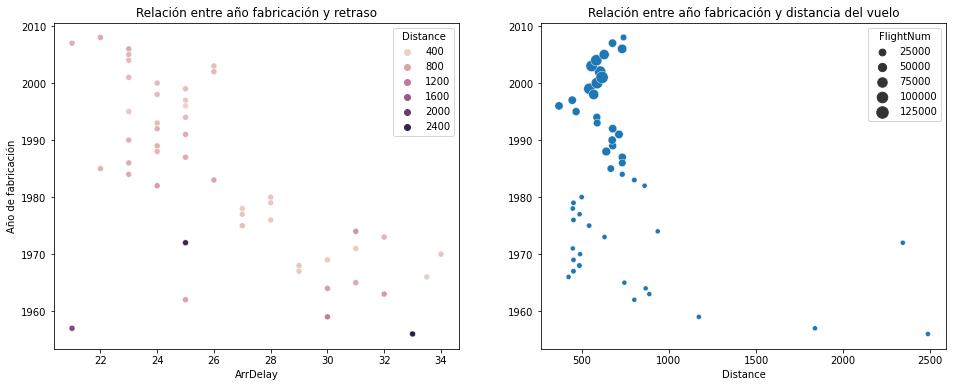

In [99]:

# Preparar datos
delay_yoM=df.groupby(['YearOfManufact']).agg({'ArrDelay':'median',
                                              'Distance':'median',
                                              'FlightNum':'count'}).sort_values(by=('ArrDelay'), ascending=False)

# Crear figura

fig, (ax1,ax2) = plt.subplots(figsize=(16,6),ncols=2,nrows=1)

#ax - Retraso vs año de fabricación
sns.scatterplot(data=delay_yoM,
                x='ArrDelay',
                y='YearOfManufact',
                hue='Distance',
                ax=ax1)

# Customizar la imagen
# Añadir titulos
ax1.set(title='Relación entre año fabricación y retraso',
       ylabel='Año de fabricación',)


#ax2 - Distancia vs año de fabricación
sns.scatterplot(data=delay_yoM,
                y='YearOfManufact',
                x='Distance',
                size='FlightNum',
                sizes=(25,150),
                ax=ax2);

# Customizar la imagen
# Añadir titulos
ax2.set(title='Relación entre año fabricación y distancia del vuelo',
       ylabel='',);



Lo que podemos deducir de estos gráficos es:

1. Parece que hay una cierta tendencia a que aviones más antiguos acumulen más retrasos pero no es muy clara.
2. La mayoría de los vuelos son operados por aviones con fecha de fabricación mayor de 1990.
3. Distancias de vuelo promedio superior a 1500 km son operadas poraviones de entre 1960 y 1975.
4. Más de un 70% de los trayectos tienen una distancia inferior a las 1000 millas.


## 3.4. Origenes y destinos.

Arranco esta sección haciendome una preguna: ¿influye en el retraso el origen y el destino de mi viaje? Podría tener cierta lógica que aeropuertos con más tráfico acumulen más retrasos, vamos a ver lo que nos dicen los datos.


### 3.4.1. Aeropuertos. Volumen de tráfico y retraso medio.

Vamos a ver cuales son los aeropuertos con mayor número de salidas y cual es su tiempo promedio de retraso a la salida.

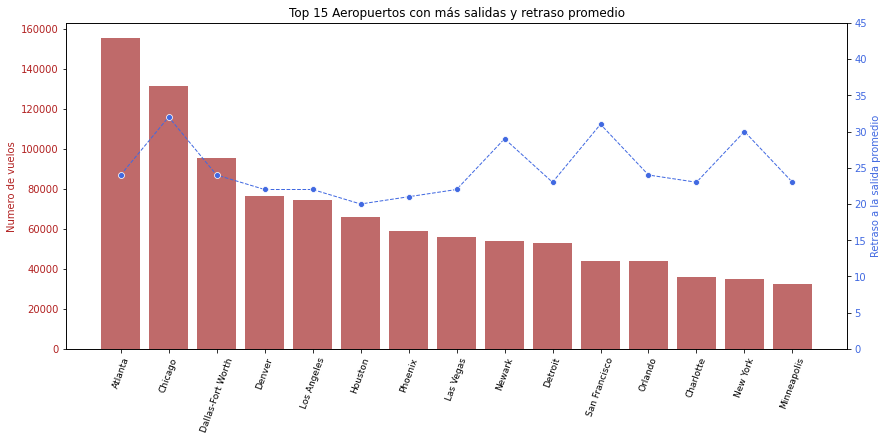

In [100]:
fig,ax=plt.subplots(figsize=(14,6))

# Top.15 Aeropuertos con mayor número de salidas
airports=df.groupby(['Origin',
                     'city_or',
                     'state_or']).agg({'FlightNum':'count',
                                       'DepDelay':'median'}).sort_values(by='FlightNum',ascending=False).head(15)

#AX1. Top 15 aeropuertos por número de vuelos.
sns.countplot(data=df,
              x='city_or',
              order=df.city_or.value_counts().iloc[:15].index,
              #palette='Reds_r',
              color='indianred')

# Ax1 custom.
ax.set_title('Top 15 Aeropuertos con más salidas y retraso promedio')
ax.set_xlabel(None)
ax.tick_params(axis='x',labelsize=9, rotation=70)
ax.set_ylabel("Numero de vuelos",color="firebrick")
ax.tick_params(axis='y',labelcolor='firebrick')


# Segundo eje
ax2=ax.twinx()

# plot Ax2
sns.lineplot(data=airports,
             x='city_or',
             y='DepDelay',
             color='royalblue',
             linewidth=1,
             linestyle='--',
             marker='o',
             ax=ax2)

# Ax2 Custom
ax2.set_ylabel("Retraso a la salida promedio",color="royalblue")
ax2.tick_params(axis='y',labelcolor='royalblue')
ax2.set_ylim((0,45));


En este gráfico podemos observar que el aeropuerto de atlanta consigue unos tiempos de retraso inferiores a los esperados teniendo en cuenta en número de vuelos que tiene. 

Además vemos que hay una tendencia a disminuir el retraso a la salida conforme disminuye el tráfico hasta un cierto valor de trafico anual (entre 60k y 70k vuelos anuales) por debajo del cual parece que vuelve a aumentar el retraso.

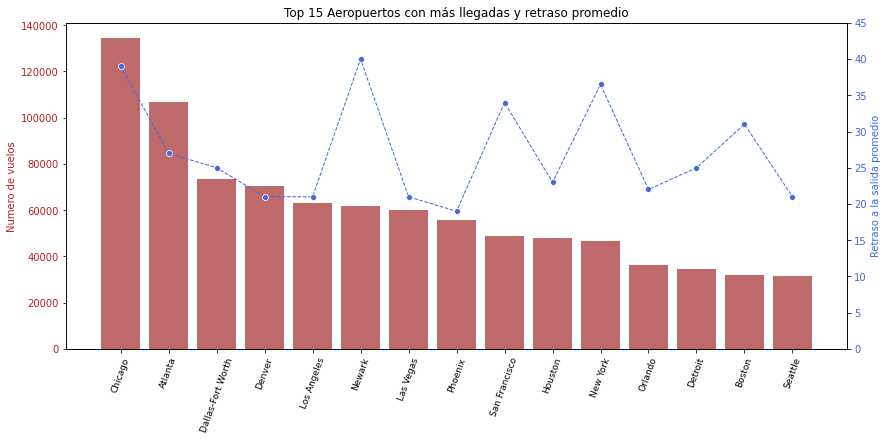

In [101]:

fig,ax=plt.subplots(figsize=(14,6))

# Top.15 Aeropuertos con mayor número de llegadas
airports_dest=df.groupby(['Dest',
                     'city_dest',
                     'state_dest']).agg({'FlightNum':'count',
                                         'ArrDelay':'median'}).sort_values(by='FlightNum',ascending=False).head(16)


#AX1. Top 15 aeropuertos por número de vuelos.
sns.countplot(data=df,
              x='city_dest',
              order=df.city_dest.value_counts().iloc[:15].index,
              #palette='Reds_r',
              color='indianred')

# Ax1 custom.
ax.set_title('Top 15 Aeropuertos con más llegadas y retraso promedio')
ax.set_xlabel(None)
ax.tick_params(axis='x',labelsize=9, rotation=70)
ax.set_ylabel("Numero de vuelos",color="firebrick")
ax.tick_params(axis='y',labelcolor='firebrick')


# Segundo eje
ax2=ax.twinx()

# plot Ax2
sns.lineplot(data=airports_dest,
             x='city_dest',
             y='ArrDelay',
             color='royalblue',
             linewidth=1,
             linestyle='--',
             marker='o',
             ax=ax2)

# Ax2 Custom
ax2.set_ylabel("Retraso a la salida promedio",color="royalblue")
ax2.tick_params(axis='y',labelcolor='royalblue')
ax2.set_ylim((0,45));



En este caso no se observa una tendencia clara, puesto que el retraso a la llegada está influido por el retraso a la salida.

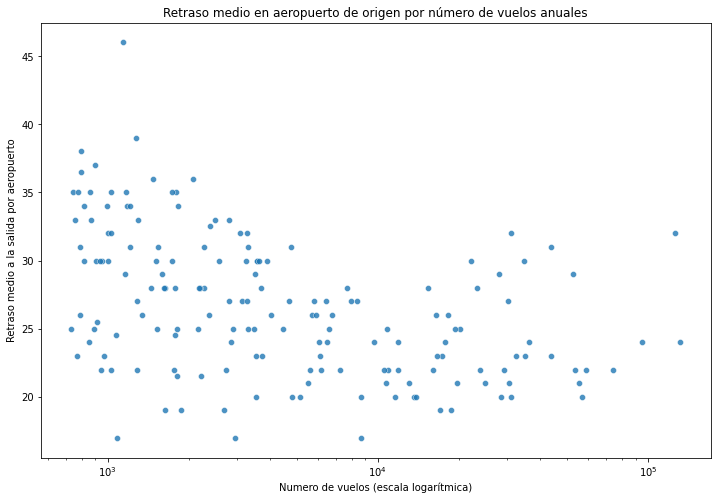

In [102]:
# Aerpuertos de origen y retraso.
origen=df.groupby(['Origin','city_or','state_or']).agg({'DepDelay':'median','FlightNum':'count'}).sort_values(by='DepDelay',ascending=False)

# Crear fig / ax
fig,ax=plt.subplots(figsize=(12,8))

# Ax - Retraso medio en aeropuerto de origen por número de vuelos anuales 
sns.scatterplot(data=origen.query('FlightNum>732'),
                y='DepDelay',
                x='FlightNum',
                alpha=0.8)

# Escala logarítmica
plt.xscale('log')

# Custom
ax.set(title='Retraso medio en aeropuerto de origen por número de vuelos anuales',
       xlabel='Numero de vuelos (escala logarítmica)',
       ylabel='Retraso medio a la salida por aeropuerto');

Parece que existe tendencia a que aeropuertos con menos tráfico presenten mayor retraso medio de salida, cambiando esta tendencia en aerpuertos a partir de 10.000 vuelos anuales.

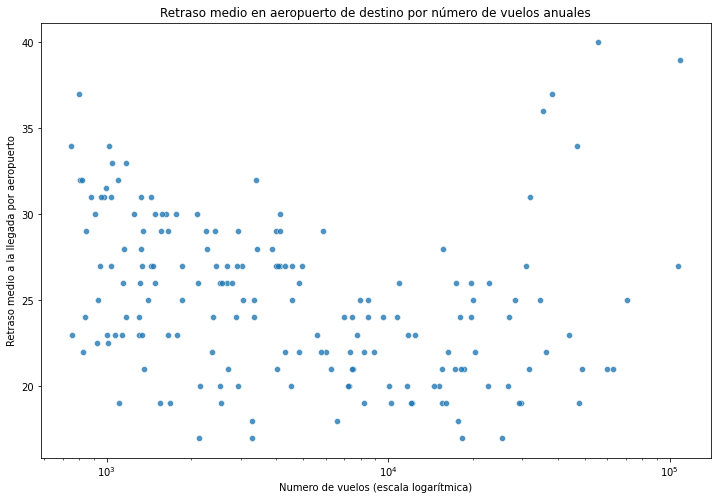

In [103]:
# Aeropuertos de destino y retrasos.
destino=df.groupby(['Dest','city_dest','state_dest']).agg({'ArrDelay':'median','FlightNum':'count'}).sort_values(by='ArrDelay',ascending=False)

# Crear fig / ax
fig,ax=plt.subplots(figsize=(12,8))

# Ax - Retraso medio en aeropuerto de origen por número de vuelos anuales 
sns.scatterplot(data=destino.query('FlightNum>732'),
                y='ArrDelay',
                x='FlightNum',
                alpha=0.8)

# Escala logarítmica
plt.xscale('log')

# Custom
ax.set(title='Retraso medio en aeropuerto de destino por número de vuelos anuales',
       xlabel='Numero de vuelos (escala logarítmica)',
       ylabel='Retraso medio a la llegada por aeropuerto');

Para aeropuertos con menos de 20.000 vuelos al año (55 vuelos diarios) no se observan tendencia claras entre el retraso y el tráfico. Para aeropuertos con más tráfico parece que hay una ligera tendencia a que  aeropuertos con más tráfico el retraso promedio a la llegada es mayor. 

### 3.4.2. Estados con mayor volumen de viajeros. Volumen de tráfico y retraso medio.

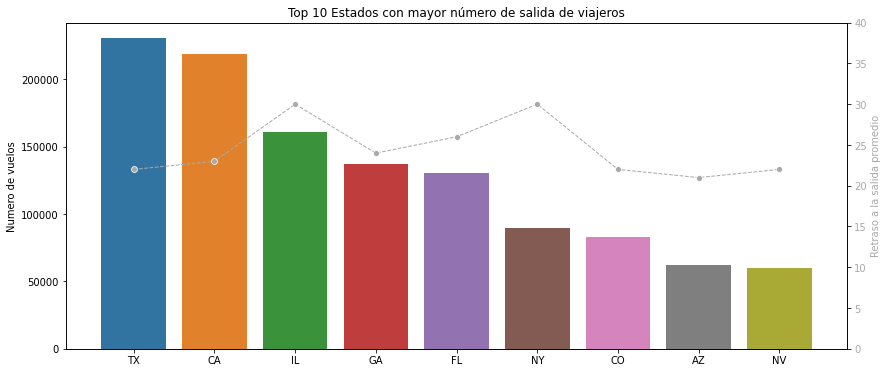

In [104]:

fig,ax=plt.subplots(figsize=(14,6))

# Estados de origen, número de vuelos y retraso.
estados_or=df.groupby(['state_or']).agg({'FlightNum':'count',
                                         'DepDelay':'median'}).sort_values(by='FlightNum',ascending=False)[0:9]

#AX1. Top 10 Estados de origen.
sns.barplot(data=estados_or,
                y='FlightNum',
                x=estados_or.index,)

# Ax1 custom.
ax.set_title('Top 10 Estados con mayor número de salida de viajeros')
ax.set_xlabel(None)
ax.set_ylabel("Numero de vuelos")

# Segundo eje
ax2=ax.twinx()

# plot Ax2
sns.lineplot(data=estados_or,
             x=estados_or.index,
             y='DepDelay',
             color='darkgrey',
             linewidth=1,
             linestyle='--',
             marker='o',
             ax=ax2)

# Ax2 Custom
ax2.set_ylabel("Retraso a la salida promedio",color="darkgrey")
ax2.tick_params(axis='y',labelcolor='darkgrey')
ax2.set_ylim((0,40));





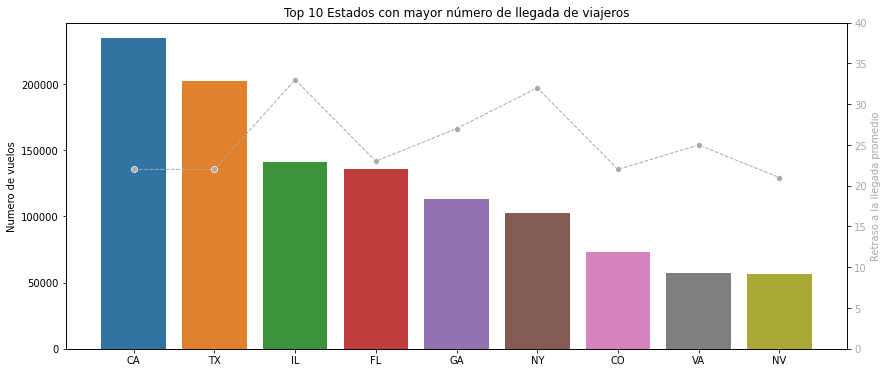

In [105]:
fig,ax=plt.subplots(figsize=(14,6))

# Estados de destino, número de vuelos y retraso
estados_dest=df.groupby(['state_dest']).agg({'FlightNum':'count',
                                             'ArrDelay':'median'}).sort_values(by='FlightNum',ascending=False)[0:9]

#AX1. Top 10 Estados de origen.
sns.barplot(data=estados_dest,
                y='FlightNum',
                x=estados_dest.index,)

# Ax1 custom.
ax.set_title('Top 10 Estados con mayor número de llegada de viajeros')
ax.set_xlabel(None)
ax.set_ylabel("Numero de vuelos")

# Segundo eje
ax2=ax.twinx()

# plot Ax2
sns.lineplot(data=estados_dest,
             x=estados_dest.index,
             y='ArrDelay',
             color='darkgrey',
             linewidth=1,
             linestyle='--',
             marker='o',
             ax=ax2)

# Ax2 Custom
ax2.set_ylabel("Retraso a la llegada promedio",color="darkgrey")
ax2.tick_params(axis='y',labelcolor='darkgrey')
ax2.set_ylim((0,40));


Los cinco estados con mayor tráfico aéreo son California, Texas, Ilinois, Florida y Georgia. El retraso promedio en estos estados está entre 20 y 25 minutos, salvo en el caso de Ilinois que se dispara hasta los 30 minutos.

### 3.4.3. Rutas aéreas. Volumen de tráfico y retraso medio.

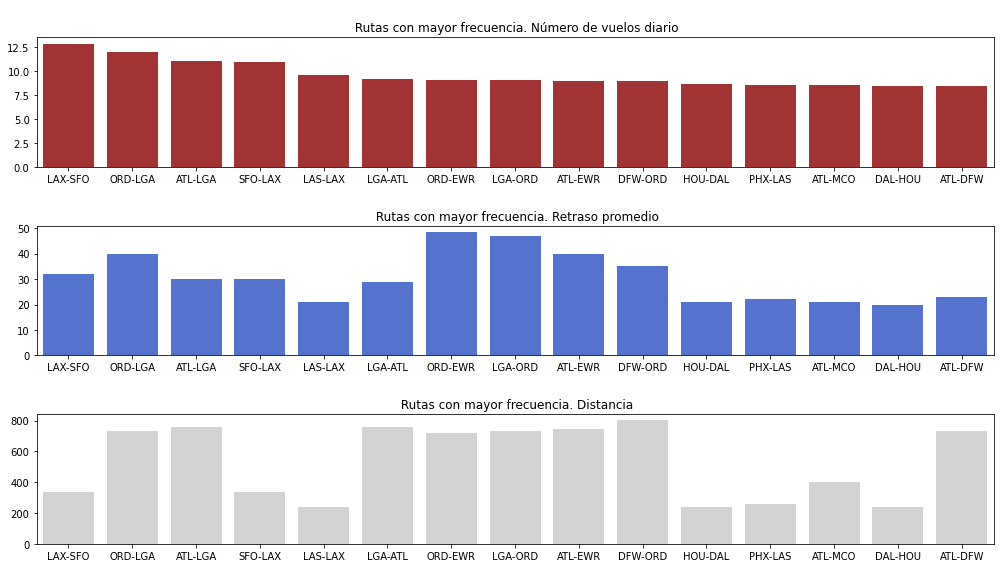

In [106]:
# Top.15 Trayectos con mayor número viajes
fig,(ax1,ax2,ax3)=plt.subplots(figsize=(14,8),ncols=1,nrows=3,tight_layout=True)

# Top.15 Trayectos con mayor número viajes
rutas=df.groupby('Skyway').agg({'FlightNum':'count',
                               'ArrDelay':'median',
                               'Distance':'mean'}).sort_values(by='FlightNum',ascending=False)[0:15]
rutas['Flights_per_day']=round(rutas.FlightNum/366,1)


#AX1. Top 15 aeropuertos por número de vuelos.
sns.barplot(data=rutas,
                y='Flights_per_day',
                x=rutas.index,
                color='firebrick',
                ax=ax1)

ax1.set(title='\n Rutas con mayor frecuencia. Número de vuelos diario',
        xlabel=None,
        ylabel=None)

#AX2. Top 15 aeropuertos por número de vuelos.
sns.barplot(data=rutas,
                y='ArrDelay',
                x=rutas.index,
                color='royalblue',
                ax=ax2
               )
ax2.set(title='\n Rutas con mayor frecuencia. Retraso promedio',
        xlabel=None,
        ylabel=None)

#AX1. Top 15 aeropuertos por número de vuelos.
sns.barplot(data=rutas,
                y='Distance',
                x=rutas.index,
                color='lightgray',
                ax=ax3
               )
ax3.set(title='\n Rutas con mayor frecuencia. Distancia',
        xlabel=None,
        ylabel=None);

## 3.5. Causas de los retrasos.

Para estimar la mediana del retraso según la causa podría caer en la tentación de agrupar usando la función aggregate.

In [107]:
df[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']].agg(('median'))

CarrierDelay         2.0
WeatherDelay         0.0
NASDelay             2.0
SecurityDelay        0.0
LateAircraftDelay    8.0
dtype: float64

Pero en este caso es más significativo que tenga en cuenta solo aquellos casos que se puedan imputar a cada causa, es decir que deberíamos filtrar y solo hallar el promedio para los casos que sean mayores que cero. 

In [108]:
causa_retraso=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
for var in causa_retraso:
    print('\n En un ',round(df[df[var]>0][var].count()/df[var].count()*100,1),'% de las ocasiones se imputa un retraso a ', var, 'y el valor de la mediana es: ',round(df[df[var]>0][var].median(),1), ' minutos')


 En un  52.6 % de las ocasiones se imputa un retraso a  CarrierDelay y el valor de la mediana es:  20.0  minutos

 En un  7.9 % de las ocasiones se imputa un retraso a  WeatherDelay y el valor de la mediana es:  25.0  minutos

 En un  52.8 % de las ocasiones se imputa un retraso a  NASDelay y el valor de la mediana es:  13.0  minutos

 En un  0.5 % de las ocasiones se imputa un retraso a  SecurityDelay y el valor de la mediana es:  13.0  minutos

 En un  55.4 % de las ocasiones se imputa un retraso a  LateAircraftDelay y el valor de la mediana es:  29.0  minutos


# 4. Conclusiones.


En este notebook, he trabajado principalmente diferentes funcionalidades de la librería de python Pandas para tratamiento de datos. A lo largo del ejercicio he cargado diferentes archivos en formato CSV y he limpiado y preprocesado los datos. 

A continuación he trabajado con diferentes opciones de unir los dataframes para extraer datos de otras tablas.

Por último he utilizado las funcionalidades que proporciona Pandas para agrupar los datos en funciones de diferentes variables para intentar extraer información.

En el siguiente ejercicio añadiré o mejoraré los gráficos que acompañam al dataframe.

Como principales obtenidos del análisis del dataset tenemos los siguientes:

- Extiste una relación entre el número de vuelos y la fecha.
- En el global se oberva tendencia de que a mayor número de vuelos mayor retrasos.
- Los días festivos (4/7 o 25/12)se observan menos tráfico y menos proporción de retrasos.
- El restraso a la salida está linealmente relacionado con el retraso a la llegada.
- Aviones más antiguos tienden a tener mayores retrasos.
- Los retrasos más comunes se deben a la compañía, al vuelo anterior o la NAS.
- Es difícil observar un patron claro entre aeropuertos, tráfico aéreo y retraso, (probablemente se deberían de analizar otras variables y tener más información sobre la casuística de aeropuertos más relevantes) pero parece que se podría ver una curva en forma de U, es decir conforme crece el volumen de vuelos de un aeropuerto se observa menor retraso hasta que se llega a un mínimo y entonces los retrasos empiezan a crecer de nuevo con el número de vuelos. 